In [1]:
from google.colab import drive
drive.mount('/content/drive') #you need to upload the folder in drive or change your path here.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
generes=["unknown","Action","Adventure","Animation","Children's","Comedy","Crime","Documentry","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]
print(len(generes)) #as there are only 19 generes according to readme I manually added them list for easy graph creation.


19


In [3]:
graph_temp ={}
with open("/content/drive/MyDrive/ml-100k/u.data") as fp: #u.data is training data and is read.
    for line in fp:
      line_data = line.split('\t')
      user = int(line_data[0])
      movie = int(line_data[1])
      rating =int(line_data[2])            #as every line is of same format splitting based on demiliter.
      if user not in graph_temp:
        graph_temp[user] = {}  #if user not in dictionary put user as key with value as empty dictionary for movie and generes nodes.
      movie_rating =(movie,rating)
      graph_temp[user][movie_rating] = set() # for every user it has internal dictionary of (movie,rating) as key and set for generes to be added later. this indicated users direct edges to (movies,rating) nodes and from (movies,rating) nodes having direct edge to generes.


In [4]:
print(len(graph_temp)) #This will be N in the formula for initializing because N are the sources that have 0 incoming edges and in my graph users have 0 incoming edges and from them only connections happen so this is my N.

943


In [5]:
movie_names=[] #a list to store movie names while reading u.item to get movie names for recommendations.
with open("/content/drive/MyDrive/ml-100k/u.item",encoding = "ISO-8859-1") as fp: #reading u.item for generes and completing the graph.
    for line in fp:
      line_data = line.split('|')
      line_data[len(line_data)-1]= line_data[len(line_data)-1].split('\n')[0]
      movie = int(line_data[0])
      movie_names.append(line_data[1])
      movie_generes =[]
      for i in range(5,24):
        if line_data[i] == '1':       #if we divide based on the dimiter ('|') we get from 5 , 24 indices are what generes they belong to so 5- respctive for label will give us correct genre from generes list.
          movie_generes.append(generes[i-5])
      for user in graph_temp:
        for movie_rating in graph_temp[user]:
          if(movie_rating[0]==movie):
            for g in movie_generes :                   # adding the index of the genre to set of (movie,rating) nodes for each user.
              graph_temp[user][movie_rating].add(g)    #how this graph structure is explained clearly on word prompt that is pasted as picture below.

In [6]:
#for user in graph_temp:
  #print("user is" +" " + str(user))
  #print(graph_temp[user])

In [7]:
#print(movie_names)
#print(len(graph_temp))
#print(len(movie_names))

In [8]:
#print(graph_temp)

In [9]:
max_movie_rated = 0
min_movie_rated = float('inf')              #just finding minimum and maximum movies rated by each user.
for user in graph_temp:
  max_movie_rated = max(len(graph_temp[user]),max_movie_rated)
  min_movie_rated = min(min_movie_rated, len(graph_temp[user]))

In [10]:
print("The maximum movies rated by any user :-" +" " + str(max_movie_rated))
print("The minimum movies rated by any user :-" +" " + str(min_movie_rated))

The maximum movies rated by any user :- 737
The minimum movies rated by any user :- 20


In [11]:
max_generes = 0
min_genere = float('inf')
for user in graph_temp:                  #finding minimum and maximum generes associated for a movie.
  for movie in graph_temp[user]:
    max_generes = max(max_generes,len(graph_temp[user][movie]))
    min_genere = min(min_genere, len(graph_temp[user][movie]))

In [12]:
print("the maximum number of genres attached for any movie is :-" + " " + str(max_generes))
print("the minimum number of genres attached for any movie is :-" + " " + str(min_genere))

the maximum number of genres attached for any movie is :- 6
the minimum number of genres attached for any movie is :- 1


## Justification for my graph storage and topic set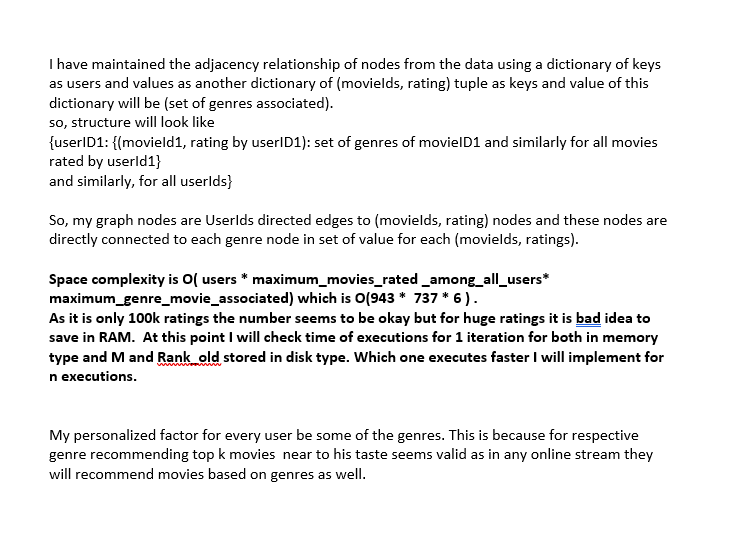

In [13]:
M = open('M','w')
for user in graph_temp:
  userid = user
  x=''
  movie_destinations=[]
  degree = len(graph_temp[userid])
  for movie in graph_temp[user]:                         #for method-1 in order to store M in disk creation of M file.
    movie_destinations.append(movie)
    genre_destinations=[]
    for genre in graph_temp[user][movie]:
      genre_destinations.append(genre)
    y= str(movie) + "*" + str(len(graph_temp[user][movie])) +'*'+ str(genre_destinations)  # I added * so that while reading this M for every time  I can directly use this delimiterfor getting movie as source and movie edges as degree and generes as sources to apply formula.
    x= x+y+"||"
  x = x[:-2]
  line = str(userid) + "#" + str(degree) +"#" + str(movie_destinations) + "#" + x # the previus x is now added with same intention for users.
  #line_array = line.split('#')
  #print(line_array[3])
  M.write(line)
  M.write("\n")
M.close()

#My M will be of the form User # user degree # movie node counts + movie * move edges * generes.
#implies source#degree#destinations format and as it is tripartite it will be nested.


In [14]:
rank_new ={}
rank_old ={}
for user in graph_temp:
  if user not in rank_new:
    rank_new[user]={}
    rank_old[user]={}                                #creating rank_new and rank_old vectors initially which will be of the form {user : {(movieId,genere),0}}
  for movie_rating in graph_temp[user]:
    for genre in graph_temp[user][movie_rating]:
      movie_genre =(movie_rating[0],genre)
      rank_new[user][movie_genre] = 0
      rank_old[user][movie_genre] =0

In [15]:
N = 943 #reason mentioned above.

for user in rank_new :
  for movie_genre in rank_new[user]: #initially filling this vectors 1/N value before algorithm implementation.
    rank_new[user][movie_genre] = 1/N
    rank_old[user][movie_genre] = 1/N


In [16]:
rank_old0 = open('rank_old', 'w')
for user in rank_new :
  rank_old0.write(str(user) + "$" + str(rank_new[user])) #writing rank-old to file based on purposedly created demilited so rank_old file will be of the format user$ {(movieid,genere):1/N.....}
  rank_old0.write("\n")

rank_old0.close()



In [17]:
topic_set = set()
selected_topics = ['Comedy','Crime','Thriller']
for topic in selected_topics: # I have taken 3 genres as topics_set means teleporting will be done to only these topics in the algorithm.
  topic_set.add(topic)

##IMPLEMENTATION FOR ONE ITERATION IF M IS STORED IN DISK AND RANK OLD STORED IN DISK

In [18]:
beta = 0.85
from ast import literal_eval
import time           #initially this is to know th etime of executions of methods so taken beta to be 0.85 as general.

In [19]:
start = time.time()
for i in range(0,1):
  destinations = []
  degrees = {}
  for user in rank_new:
    with open(r"M",'r') as f:
      for line in f :
        split = line.split('#')
        user_from_M = int(split[0])
        if user == user_from_M :
          movie_genre_cache = split[3].split('||')
          for x in movie_genre_cache:
            y = x.split('*')                                                  #preprocessing M to get source, destinations and degree for calculating.
            generes = literal_eval(y[2])
            node= literal_eval(y[0])
            #print(node)
            degrees[int(node[0])] = int(y[1])
            for genere in generes:
              destinations.append((int(node[0]),str(genere)))
          break

    r_old_values={}
    with open(r"rank_old",'r') as f:
      for line in f:
        line_data = line.split('$')
        if(int(line_data[0])==user) :                           #preprocessing rank_old for computing
          r_old_dictionary = literal_eval(line_data[1])
          for key in r_old_dictionary:
            #node = literal_eval(key)
            r_old_values[(int(key[0]),str(key[1]))] = r_old_dictionary[key]
          break

    for new_destination in destinations:
      node = (int(new_destination[0]),str(new_destination[1]))
      for j in range(1,degrees[new_destination[0]]+1):
        new_node = (int(new_destination[0]), str(new_destination[1]))
        if ((new_node in rank_new[user]) and (node in r_old_values)):
          if(node[1] in topic_set):                                                                       #followed the pagerank algorithm and extracted required terms .
              rank_new[user][new_node] = beta*(r_old_values[node]/degrees[node[0]]) + (1-beta)/3  #as topicset size is 3 only and teleporting only for respective nodes that have generes in the topic set.
          else:
              rank_new[user][new_node] = beta*(r_old_values[node]/degrees[node[0]])


    sum=0
    for movie_rating in graph_temp[user]:
      degree = len(graph_temp[user][movie_rating])
      for genre in graph_temp[user][movie_rating]:        #at end of every iteration adding 1-sum/N to reduce leakege of score due to deadends.
        node =(movie_rating[0],genre)
        sum += rank_new[user][node]


    for node in rank_new[user] :
      rank_new[user][node] += (1-sum)/N



  rank_old1 = open('rank_old', 'w')
  for user in rank_new :
    rank_old1.write(str(user) + "$" + str(rank_new[user]))   #at the end of each iteration r_old will be computed r_new.
    rank_old1.write("\n")

  rank_old1.close()

endtime = time.time()










In [20]:
print("the time of execution in implementing M stored in disk and rank_old stored in disk is :- " +" " + str(endtime-start))

the time of execution in implementing M stored in disk and rank_old stored in disk is :-  315.9503960609436


## IMPLEMENTATION FOR ONE ITERATION IF MY M and RANK_OLD ARE IN MEMORY.

In [21]:
start = time.time()
for i in range(0,1) :
  for user in rank_new :
    #movie_rating_dictionary = graph_temp[user]
    for movie_rating in graph_temp[user]:
      degree = len(graph_temp[user][movie_rating])
      for genre in graph_temp[user][movie_rating]:
        node =(movie_rating[0],genre)
        if genre in topic_set :
          rank_new[user][node] = (beta)* (rank_old[user][node]/degree) + (1-beta)/3
        else:
          rank_new[user][node] = (beta)* (rank_old[user][node]/degree)                                          #exactly the same process but here M and r_new and r_old will be in memory but the logic is same as above.

  #rank_old = rank_new
  sum=0
  for movie_rating in graph_temp[user]:
    degree = len(graph_temp[user][movie_rating])
    for genre in graph_temp[user][movie_rating]:
      node =(movie_rating[0],genre)
      sum += rank_new[user][node]

  for node in rank_new[user] :
    rank_new[user][node] += (1-sum)/N

  for user in rank_new :
    for movie_genre in rank_new[user]:
      rank_old[user][movie_genre] = rank_new[user][movie_genre]


end = time.time()

In [22]:
print("the time of execution in implementing graph stored in memory and rank_old stored in memory is :- " +" " + str(end-start))

the time of execution in implementing graph stored in memory and rank_old stored in memory is :-  0.3788573741912842


## IF YOU NOTE THE TIME OF EXECUTIONS FOR 1 ITERATION FOR BOTH THE METHODS. THE METHOD WITH THE STORING OF GRAPH IN MEMORY AND RANK_OLD IN MEMORY EXECUTED SO QUICKLY . SO TO CHECK THE ITERATIONS CONVERGENCE POINT WE NEED LOT OF ITERATIONS AND IT IS BETTER TO EXECUTE THE APPROACH WHICH GIVES BEST TIME. FOR THIS REASON EVEN THOUGH THE METHOD THAT STORES M IN DISK AND RANK_OLD IN DISK IS SPACE EFFICIENT I AM OPTIMIZING THE TIME OF EXECUTION AND AS MATTER OF FACT OPTIMIZING THE TIME OF EXECUTION REQUIRES SPACE TRADE OFF. SO OPTIMAL TIME OF EXECUTION VIEW I AM SELECTING THE APPOACH OF M IN MEMORY AND RANK_OLD IN MEMORY.

In [23]:
#------------------------------------------------------------------------------------------------------------------------------------#

## IMPLEMENTATION FOR 250 ITERATIONS AND FINDING THE CONVERGENCE

In [24]:
N = 943
for user in rank_new :
  for movie_genre in rank_new[user]:                          #initiallizations and reason mentioned above.
    rank_new[user][movie_genre] = 1/N
    rank_old[user][movie_genre] = 1/N

In [25]:
beta = 0.85 #as first step to determine iterations I am fixing 0.85 beta as standard value but this value will also be explored below.

In [26]:
import math

In [27]:
#global sum_of_errors
def error_calculation_per_iteration(rank_old, rank_new,sum_of_errors):
  n=0
  for user in rank_old :
    for pair in rank_old[user]:                                                               #this function calculates errors from rank_old and rank_new and this method is called for every iteration to find convergence.
      sum_of_errors += math.pow((rank_old[user][pair] - rank_new[user][pair]),2)
      n +=1

  return math.sqrt(sum_of_errors/n)
    #error = sum_of_errors/ len(rank_old[user])




In [28]:
iterations=[]
errors=[]
for i in range(0,250) :
  for user in rank_new :
    #movie_rating_dictionary = graph_temp[user]
    for movie_rating in graph_temp[user]:
      degree = len(graph_temp[user][movie_rating])
      for genre in graph_temp[user][movie_rating]:                                                              #the iteration algorithm is implemented  with the same logic everything which was mentioned above.
        node =(movie_rating[0],genre)
        if genre in topic_set :
          rank_new[user][node] = (beta)* (rank_old[user][node]/degree) + (1-beta)/3
        else:
          rank_new[user][node] = (beta)* (rank_old[user][node]/degree)           #the formula beta*rold[node]/degree + (1-beta)/3 if the movie is in that genere or else 0.

    sum=0
    for movie_rating in graph_temp[user]:
      degree = len(graph_temp[user][movie_rating])
      for genre in graph_temp[user][movie_rating]:
        node =(movie_rating[0],genre)
        sum += rank_new[user][node]


    for node in rank_new[user] :                            #this is to reduce leakge of score due to deadends
      rank_new[user][node] += (1-sum)/N

  errors.append(error_calculation_per_iteration(rank_old, rank_new,0)) #here every iteration's error is added to list with iteration count to get plot.
  iterations.append(i)

  for user in rank_new :                               # at the end of each iteration rank_old = rank_new.
    for movie_genre in rank_new[user]:
      rank_old[user][movie_genre] = rank_new[user][movie_genre]


In [29]:
import matplotlib.pyplot as plt

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np

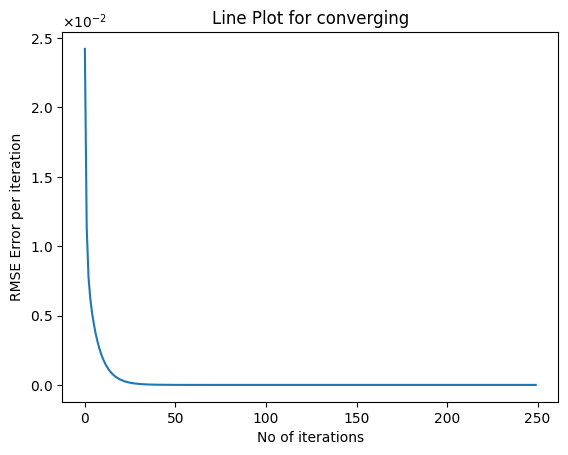

In [31]:
plt.plot(iterations, errors)
#plt.scatter(x, y, c='red', marker='o', label='Data Points',)  # 'o' is for circle markers

plt.xlabel('No of iterations')
plt.ylabel('RMSE Error per iteration')
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)                                              #plotting error per iteration vs no of iterations.
formatter.set_powerlimits((0, 0))

plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Line Plot for converging')
plt.show()

In [32]:
i =1
for error in errors:
  print("the error for iteration " +" " + str(i) +" " + "is :-" + " " + str(error))
  i+=1

the error for iteration  1 is :- 0.02421542834620834
the error for iteration  2 is :- 0.011410920056532853
the error for iteration  3 is :- 0.007777835883289195
the error for iteration  4 is :- 0.006205045044157751
the error for iteration  5 is :- 0.005167962246478267
the error for iteration  6 is :- 0.004350694931635691
the error for iteration  7 is :- 0.0036733432482240875
the error for iteration  8 is :- 0.003104579167921182
the error for iteration  9 is :- 0.0026252600433917138
the error for iteration  10 is :- 0.0022207997703150776
the error for iteration  11 is :- 0.0018792733057074944
the error for iteration  12 is :- 0.0015907414203759616
the error for iteration  13 is :- 0.0013468742015896565
the error for iteration  14 is :- 0.0011406762876776239
the error for iteration  15 is :- 0.0009662663704373218
the error for iteration  16 is :- 0.0008186954403269002
the error for iteration  17 is :- 0.0006937958053216119
the error for iteration  18 is :- 0.0005880553035261028
the error

# REASON FOR MY OPTIMAL ITERATION COUNT TO BE 113.
## if you see the above graph the error per iteration converges and becomes stagnet so exact at which value it is becoming stagnet we don't know from the graph so for that reason I printed error for each iteration and after seeing the values I am considering iterations value to be 113 which error value is 1.088127368759696e-10 which is significantly very very less. beyond these iterations we have more less values but I guess after 113 no need to take because of less change.

## CHOOSING BETA VALUE
 Now that I have choosen optimal iteration count I need to find optimal beta value for that I am plotting beta value vs error and check which beta value gives me optimal error.

In [33]:
beta_values=[0.65,0.7,0.75,0.8,0.85,0.9] #taking range of beta values to get optimal beta

In [34]:
beta_per_iteration={}
for beta in beta_values : #having a dictionary for which beta is key and value is list of error per iteration
  beta_per_iteration[beta] =[]


In [35]:
for beta in beta_values : #iterating per beta to plot.
  N = 943
  for user in rank_new :
    for movie_genre in rank_new[user]:
      rank_new[user][movie_genre] = 1/N            #initialization of rank-old and rank_new the reason stated above.
      rank_old[user][movie_genre] = 1/N

  for i in range(0,113) :  #after getting optimal iterations count iterating that many times.
    for user in rank_new :
    #movie_rating_dictionary = graph_temp[user]
      for movie_rating in graph_temp[user]:
        degree = len(graph_temp[user][movie_rating])
        for genre in graph_temp[user][movie_rating]:
          node =(movie_rating[0],genre)
          if genre in topic_set :
            rank_new[user][node] = (beta)* (rank_old[user][node]/degree) + (1-beta)/3      #the formula beta*rold[node]/degree + (1-beta)/3 if the movie is in that genere or else 0.
          else:
            rank_new[user][node] = (beta)* (rank_old[user][node]/degree)

    sum=0
    for movie_rating in graph_temp[user]:
      degree = len(graph_temp[user][movie_rating])
      for genre in graph_temp[user][movie_rating]:
        node =(movie_rating[0],genre)
        sum += rank_new[user][node]


    for node in rank_new[user] :
      rank_new[user][node] += (1-sum)/N                   #this is to reduce leakge of score due to deadends

    beta_per_iteration[beta].append(error_calculation_per_iteration(rank_old, rank_new,0))


    for user in rank_new :
      for movie_genre in rank_new[user]:
        rank_old[user][movie_genre] = rank_new[user][movie_genre] #at the end of each iteration rank_old = rank_new.


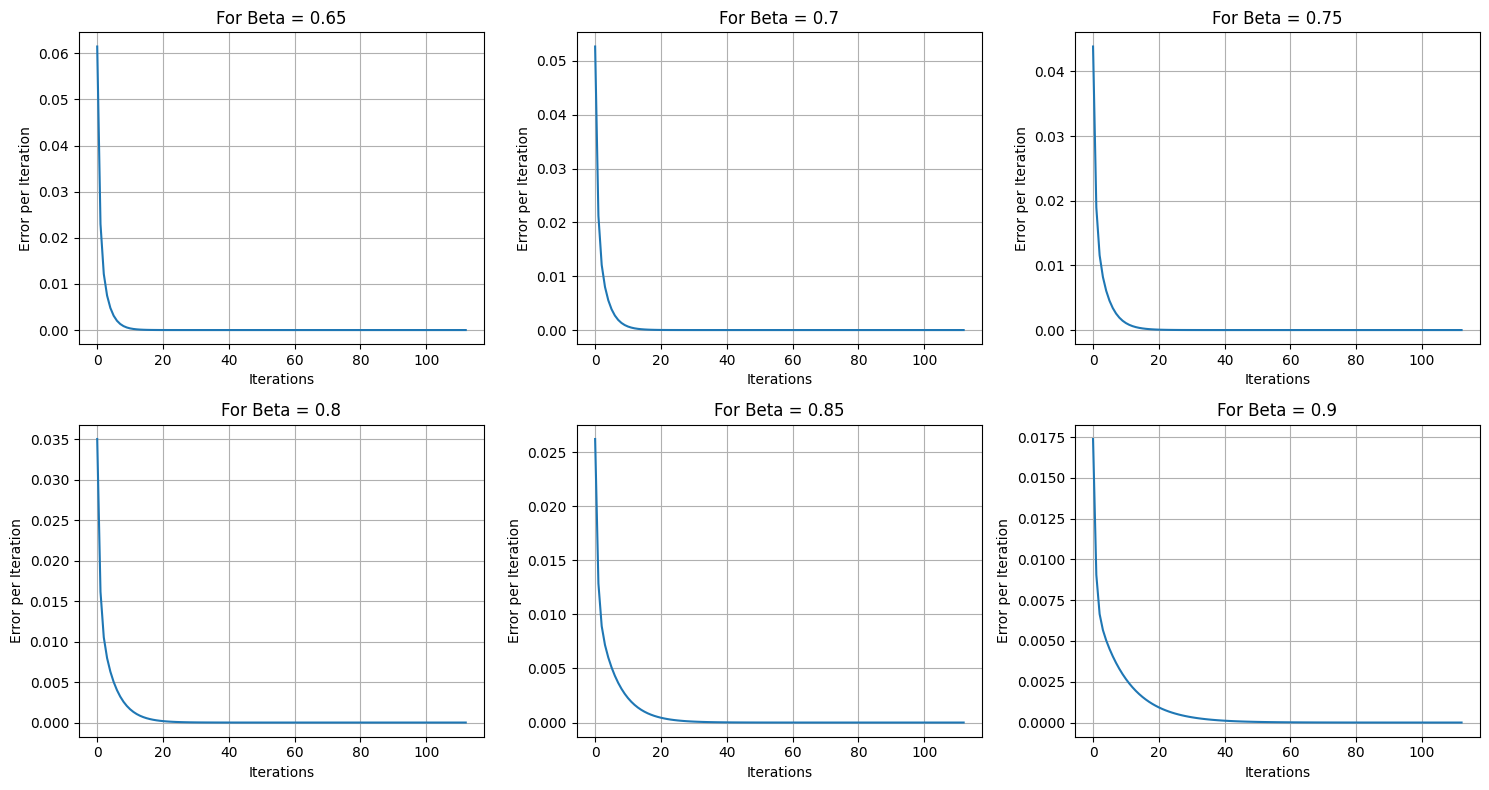

In [36]:

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i, (beta, errors) in enumerate(beta_per_iteration.items()):
    row = i // 3   #for subplots row index and column index.
    col = i % 3
    axs[row, col].plot(range(0, 113), errors)
    axs[row, col].set_xlabel('Iterations')                           #plotting error per iteration vs iteration for every beta.
    axs[row, col].set_ylabel('Error per Iteration')
    axs[row, col].set_title(f'For Beta = {beta}')
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

### If you observe the graph beta = 0.9 have faster dropping rate due to which it started from very less error and by using this we can get much more less errors fastly. But I am selecting 0.85 because to get the error value nearly 10^-10 0.9 requires more number of iterations and the completion of implementation task will take much longer time. So to avoid that I am taking 0.85 as standard eventhough 0.9 was better.

## CHOOSING K VALUES FOR EVALUATION

In [37]:
class EvaluationMetrics:
  def __init__(self, rank_new, k, graph_temp,movie_names, topic_set):
    self.rank_new = rank_new
    self.k = k
    self.graph_temp = graph_temp                     #creating a class with constructor parameters rank_new vector, k, graph_temp or M, movie_names created while reading u.item, topic_set my own 3 topics.
    self.movie_names = movie_names
    self.topic_set = topic_set

  def precision_k(self): #this function will calculate precision for each user and store in dictionary as user as key and their precision as value.
    precision_for_every_user = {}
    for user in self.rank_new:
      descending_sorted_recommendations= sorted(self.rank_new[user].items(), key=lambda x: x[1], reverse=True)   #gets top k scored elements in list of tuples.
      sum=0
      for i in range(0,self.k):
        for movie_rating in self.graph_temp[user]:
          if((movie_rating[0]==descending_sorted_recommendations[i][0][0] and movie_rating[1]>=4) and descending_sorted_recommendations[i][0][1] in self.topic_set) : #I took rating also implies my ground truth data are the movies that's genre is in topic_set and rating>=4
            sum += 1
      precision_for_every_user[user] = sum/self.k #formula and sum is incrememnting based on my logic stated above.
    return precision_for_every_user #returns dictionary.


  def average_precision_for_all_users(self):
    precision_dictionary = self.precision_k()
    total_precision_score = 0
    for user in precision_dictionary:        #this fucntion will get the dictionary from the above function and average of all user's precision will be calculated and returned.
      total_precision_score += precision_dictionary[user]
    return total_precision_score/len(self.graph_temp)


  def recall_k(self):
    recall_for_every_user = {}   #this function will calculate recall for each user and store in dictionary as user as key and their precision as value.
    for user in self.rank_new:
      descending_sorted_recommendations= sorted(self.rank_new[user].items(), key=lambda x: x[1], reverse=True) #gets top k scored elements in list of tuples.
      sum=0
      for i in range(0,self.k):
        for movie_rating in self.graph_temp[user]:
          if((movie_rating[0]==descending_sorted_recommendations[i][0][0] and movie_rating[1]>=4) and descending_sorted_recommendations[i][0][1] in self.topic_set) : #I took rating also implies my ground truth data are the movies that's genre is in topic_set and rating>=4
            sum += 1
      recall_for_every_user[user] = sum/len(descending_sorted_recommendations)  #formula and sum is incrememnting based on my logic stated above.
    return recall_for_every_user  #returns dictionary.


  def average_recall_for_all_users(self):
    recall_dictionary = self.recall_k()
    total_recall_score = 0
    for user in recall_dictionary:                  #this fucntion will get the dictionary from the above function and average of all user's recall will be calculated and returned.
      total_recall_score += recall_dictionary[user]

    return total_recall_score/(len(self.graph_temp))


  def get_top_movies(self):
    recommended_movies_for_each_user = {}
    for user in self.rank_new:
      movies_received =[]
      descending_sorted_recommendations = sorted(self.rank_new[user].items(), key=lambda x: x[1], reverse=True)
      for i in range(0,self.k):                                                                                         #this function will give a dictionary with users as keys and list of tuples and tuples of the form (movieId, genre)
        movies_received.append((descending_sorted_recommendations[i][0][0],descending_sorted_recommendations[i][0][1]))
      recommended_movies_for_each_user[user] = movies_received #this function is used to print recommended movies for each user
    return recommended_movies_for_each_user






In [38]:
N = 943
for user in rank_new :
  for movie_genre in rank_new[user]:
    rank_new[user][movie_genre] = 1/N
    rank_old[user][movie_genre] = 1/N     #one final time implementing iteration algorithm after setting all the values. So initialinzing rank_new and rank-old because of the same reason.

In [39]:
beta = 0.85
for i in range(0,113) :
  for user in rank_new :
    #movie_rating_dictionary = graph_temp[user]
    for movie_rating in graph_temp[user]:
      degree = len(graph_temp[user][movie_rating])
      for genre in graph_temp[user][movie_rating]:
        node =(movie_rating[0],genre)
        if genre in topic_set :
          rank_new[user][node] = (beta)* (rank_old[user][node]/degree) + (1-beta)/3
        else:                                                                                    #the formula beta*rold[node]/degree + (1-beta)/3 if the movie is in that genere or else 0. And 3 is due to size of topic set .
          rank_new[user][node] = (beta)* (rank_old[user][node]/degree)

    sum=0
    for movie_rating in graph_temp[user]:
      degree = len(graph_temp[user][movie_rating])
      for genre in graph_temp[user][movie_rating]:
        node =(movie_rating[0],genre)
        sum += rank_new[user][node]


    for node in rank_new[user] :                                         #this is to reduce leakge of score due to deadends
      rank_new[user][node] += (1-sum)/N



  for user in rank_new :
    for movie_genre in rank_new[user]:
      rank_old[user][movie_genre] = rank_new[user][movie_genre]       #at the end of each iteration rank_old = rank_new.


In [40]:
k_values=[]
average_precision_for_all_users_for_each_k= []
average_recall_for_all_users_for_each_k =[]                  #this module will have k-values and average precision for all user in list and average recall for all the users in list to get 2 plots.
for i in range (15,31):
  evaluation = EvaluationMetrics(rank_new,i,graph_temp,movie_names,topic_set)
  average_precision_for_all_users_for_each_k.append(evaluation.average_precision_for_all_users())
  average_recall_for_all_users_for_each_k.append(evaluation.average_recall_for_all_users())
  k_values.append(i)



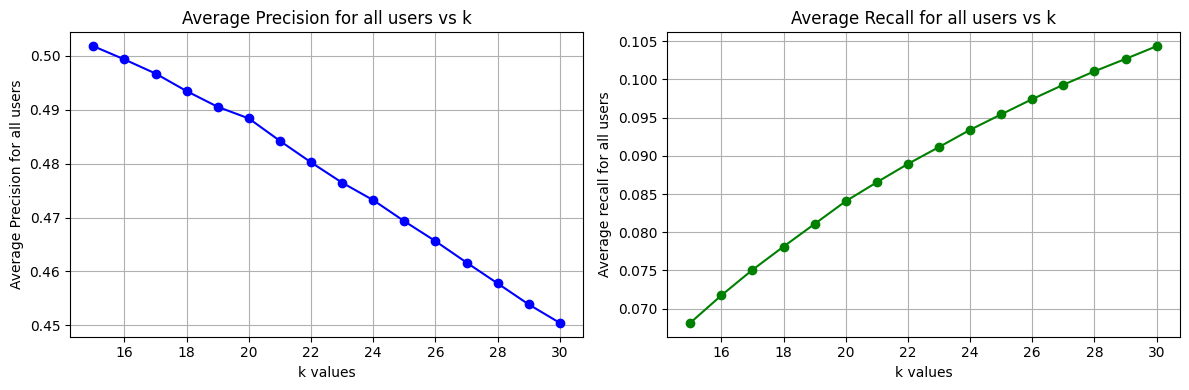

In [41]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_values, average_precision_for_all_users_for_each_k, marker='o', linestyle='-', color='b')
plt.title('Average Precision for all users vs k')
plt.xlabel('k values')
plt.ylabel('Average Precision for all users')
plt.grid(True)

                                                                                                          #plotting 2 graphs of average precision for all users vs k and average recall for all users vs k.
plt.subplot(1, 2, 2)
plt.plot(k_values, average_recall_for_all_users_for_each_k, marker='o', linestyle='-', color='g')
plt.title('Average Recall for all users vs k')
plt.xlabel('k values')
plt.ylabel('Average recall for all users')
plt.grid(True)

plt.tight_layout()


plt.show()

## I plotted Average precision for all users for each k vs k and Average recall for all users for each k vs k. From these plots you can observe that precision is decreasing as k increases and recall is increasing as k increases . This is common observation and this plots suggest that my recommendation algorithm is perfect . This trend is observed for the reason The number of recommendations that are pertinent among those that are offered is what precision is all about. Recall is concerned with the number of recommendations given out of all the pertinent recommendations. And this is clearly explained in this link : https://chaitanyabelhekar.medium.com/recommender-system-metrics-clearly-explained-1f2ba6690216#:~:text=There%20is%20usually%20an%20inverse,among%20all%20the%20relevant%20recommendations


## **So from these 2 plots we must always take optimal k value that can be exactly in the trade of precision and recall. so in the 2 plots the k value that is exactly in the mid of 15, 30 is 22 which will will be perfect k value for the balance trade off between precision and recall.**

I haven't used NDC@K metric as in my recommendation model I am noit considering order.

In [42]:
#---------------------------------------------------------------------------------------------------------------------------------#--------------------------------#

## Evaluation

Now that we have got optimal iteration count, optimal beta value and optimal k value. We also finally applied iterative algorithm of page rank now just using created class name EvaluationMetrics for all the evaluation metrics values.

In [43]:
test_graph_temp ={}
test_users = set()
test_users_ratings ={}
with open("/content/drive/MyDrive/ml-100k/u1.test") as fp:        #here u1.test, u2.test, u3.test, u4.test and u5.test are test data you can use any file but needs to change the path.
    for line in fp:
      line_data = line.split('\t')
      user = int(line_data[0])
      movie = int(line_data[1])
      rating =int(line_data[2])
      test_users.add(user)
      if user not in test_graph_temp:
        test_graph_temp[user] = {}
        test_users_ratings[user] =[]
      test_movie_rating =(movie,rating)
      test_graph_temp[user][test_movie_rating] = set()
      test_users_ratings[user].append(test_movie_rating)                  #constructing test_graph_temp as similar to graph_temp in above.
      #at the same time creating test_users-ratings dictionary which has key :- user and value as list of tuples of the form (movie,rating)


In [44]:
generes=["unknown","Action","Adventure","Animation","Children's","Comedy","Crime","Documentry","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]
print(len(generes))


19


In [45]:
with open("/content/drive/MyDrive/ml-100k/u.item",encoding = "ISO-8859-1") as fp:
    for line in fp:
      line_data = line.split('|')
      line_data[len(line_data)-1]= line_data[len(line_data)-1].split('\n')[0]
      movie = int(line_data[0])
      #movie_names.append(line_data[1])
      movie_generes =[]
      for i in range(5,24):
        if line_data[i] == '1':
          movie_generes.append(generes[i-5])
      for user in test_graph_temp:
        for movie_rating in test_graph_temp[user]:                  #filling test_graph_temp as similar of filling of graph_temp in above by reading u.item
          if(movie_rating[0]==movie):
            for g in movie_generes :
              test_graph_temp[user][movie_rating].add(g)

In [46]:
import random
num_users = 100
random_users = random.sample(test_users, num_users)     #selecting 100 random users from the test data.
#print(random_users)

<ipython-input-46-d49530e49af2>:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_users = random.sample(test_users, num_users)     #selecting 100 random users from the test data.


In [47]:
random_users_with_last_five_ratings = {}
for user in test_users_ratings:
  last_five_ratings = test_users_ratings[user][-5:]                   #making a new dictionary using test_ratings which will have only last 5 ratings.
  random_users_with_last_five_ratings[user] = last_five_ratings

In [48]:
test_graph = {}
for user in random_users:
  if user not in test_graph:
    test_graph[user] = {}
  for pair in random_users_with_last_five_ratings[user]:      #this is the main part where test_graph is created which has random users with last 5 ratings only. and the length of nodes or users in test_graph will be 100.
     movie_generes = test_graph_temp[user][pair]
     test_graph[user][pair] = movie_generes


In [49]:
def precision_at_k(rank_new,k,graph_temp,movie_names,topic_set): #this function will calculate precision for each user and store in dictionary as user as key and their precision as value.
    precision_for_every_user = {}
    for user in rank_new:
      descending_sorted_recommendations= sorted(rank_new[user].items(), key=lambda x: x[1], reverse=True) #gets top k scored elements in list of tuples.
      if user not in graph_temp: #as we are iterating rank_new vector we must take care the case user not because in random test-graph you have only 100 users.
        continue
      sum=0
      for i in range(0,k):
        for movie_rating in graph_temp[user]:
          if((movie_rating[0]==descending_sorted_recommendations[i][0][0] and movie_rating[1]>=4) and descending_sorted_recommendations[i][0][1] in topic_set) : #I took rating also implies my ground truth data are the movies that's genre is in topic_set and rating>=4
            sum += 1
      precision_for_every_user[user] = sum/k #formula and sum is incrememnting based on my logic stated above.
    return precision_for_every_user #dictionary is returned.


def Average_precision_for_all_users(rank_new,k,graph_temp,movie_names,topic_set):
    precision_dictionary = precision_at_k(rank_new,k,graph_temp,movie_names,topic_set)
    total_precision_score = 0
    for user in precision_dictionary:                                                        #this fucntion will get the dictionary from the above function and average of all user's precision will be calculated and returned.
      total_precision_score += precision_dictionary[user]
    return total_precision_score/len(graph_temp)


def recall_at_k(rank_new,k,graph_temp,movie_names,topic_set):   #this function will calculate recall for each user and store in dictionary as user as key and their precision as value.
    recall_for_every_user = {}
    for user in rank_new:
      descending_sorted_recommendations= sorted(rank_new[user].items(), key=lambda x: x[1], reverse=True)  #gets top k scored elements in list of tuples.
      if user not in graph_temp: #as we are iterating rank_new vector we must take care the case user not because in random test-graph you have only 100 users.
        continue
      sum=0
      for i in range(0,k):
        for movie_rating in graph_temp[user]:
          if((movie_rating[0]==descending_sorted_recommendations[i][0][0] and movie_rating[1]>=4) and descending_sorted_recommendations[i][0][1] in topic_set) :  #I took rating also implies my ground truth data are the movies that's genre is in topic_set and rating>=4
            sum += 1
      recall_for_every_user[user] = sum/len(descending_sorted_recommendations)  #formula and sum is incrememnting based on my logic stated above.
    return recall_for_every_user  #dictionary is returned.


def Average_recall_for_all_users(rank_new,k,graph_temp,movie_names,topic_set):
    recall_dictionary = recall_at_k(rank_new,k,graph_temp,movie_names,topic_set)
    total_recall_score = 0
    for user in recall_dictionary:
      total_recall_score += recall_dictionary[user]    #this fucntion will get the dictionary from the above function and average of all user's precision will be calculated and returned.

    return total_recall_score/(len(graph_temp))


def get_Top_movies(rank_new,k,graph_temp,movie_names,topic_set):
    recommended_movies_for_each_user = {}
    for user in rank_new:
      movies_received =[]
      descending_sorted_recommendations = sorted(rank_new[user].items(), key=lambda x: x[1], reverse=True)
      for i in range(0,k):
        movies_received.append((descending_sorted_recommendations[i][0][0],descending_sorted_recommendations[i][0][1]))
      recommended_movies_for_each_user[user] = movies_received
    return recommended_movies_for_each_user                 #this function will give a dictionary with users as keys and list of tuples and tuples of the form (movieId, genre)


In [50]:
print("The average precision of all 100 random users is :" + "  " + str(Average_precision_for_all_users(rank_new, 22, test_graph,movie_names,topic_set)))

The average precision of all 100 random users is :  0.04681818181818183


In [51]:
print("The average recall of all 100 random users is :" + "  " + str(Average_recall_for_all_users(rank_new, 22, test_graph,movie_names,topic_set)))

The average recall of all 100 random users is :  0.010922178093145225


In [52]:
precision_for_each_user = precision_at_k(rank_new,22,test_graph,movie_names,topic_set)
for user in precision_for_each_user:
  print("precision for userid : " + str(user) + " " + "=" + " " + str(precision_for_each_user[user]))

precision for userid : 286 = 0.0
precision for userid : 200 = 0.0
precision for userid : 303 = 0.0
precision for userid : 119 = 0.045454545454545456
precision for userid : 290 = 0.0
precision for userid : 157 = 0.09090909090909091
precision for userid : 7 = 0.045454545454545456
precision for userid : 260 = 0.13636363636363635
precision for userid : 72 = 0.045454545454545456
precision for userid : 42 = 0.045454545454545456
precision for userid : 241 = 0.0
precision for userid : 254 = 0.0
precision for userid : 222 = 0.0
precision for userid : 198 = 0.0
precision for userid : 168 = 0.045454545454545456
precision for userid : 237 = 0.13636363636363635
precision for userid : 41 = 0.09090909090909091
precision for userid : 269 = 0.0
precision for userid : 121 = 0.0
precision for userid : 155 = 0.0
precision for userid : 80 = 0.09090909090909091
precision for userid : 1 = 0.0
precision for userid : 232 = 0.0
precision for userid : 83 = 0.045454545454545456
precision for userid : 54 = 0.04545

In [53]:
recall_for_each_user = recall_at_k(rank_new,22,test_graph,movie_names,topic_set)
for user in recall_for_each_user:
  print("recall for userid : " + str(user) + " " + "=" + " " + str(recall_for_each_user[user]))

recall for userid : 286 = 0.0
recall for userid : 200 = 0.0
recall for userid : 303 = 0.0
recall for userid : 119 = 0.0026455026455026454
recall for userid : 290 = 0.0
recall for userid : 157 = 0.01904761904761905
recall for userid : 7 = 0.0012121212121212121
recall for userid : 260 = 0.05084745762711865
recall for userid : 72 = 0.003289473684210526
recall for userid : 42 = 0.002577319587628866
recall for userid : 241 = 0.0
recall for userid : 254 = 0.0
recall for userid : 222 = 0.0
recall for userid : 198 = 0.0
recall for userid : 168 = 0.006578947368421052
recall for userid : 237 = 0.02912621359223301
recall for userid : 41 = 0.01680672268907563
recall for userid : 269 = 0.0
recall for userid : 121 = 0.0
recall for userid : 155 = 0.0
recall for userid : 80 = 0.03571428571428571
recall for userid : 1 = 0.0
recall for userid : 232 = 0.0
recall for userid : 83 = 0.002898550724637681
recall for userid : 54 = 0.006134969325153374
recall for userid : 16 = 0.0
recall for userid : 294 = 0.00

## Note :- Here you may see some users got precision and recall to be 0 doesn't mean that I have done wrong. That implies My criteria which I used ratings also must be >=4 and genere also must be in topic set might not have in top 22 retrived scores of that users.

In [54]:
movie_for_each_user = get_Top_movies(rank_new,22,test_graph,movie_names,topic_set)
for user in movie_for_each_user:
  movie_names_for_each_user =[]
  for pair in movie_for_each_user[user]:
    movie = pair[0]-1
    movie_names_for_each_user.append(movie_names[movie])
  print("The list of movies recommended based on topic set for user id :" +" "+ str(user) + "=" + " "+ str(movie_names_for_each_user))

The list of movies recommended based on topic set for user id : 196= ['Kolya (1996)', 'Mrs. Doubtfire (1993)', 'Shall We Dance? (1996)', 'Ace Ventura: Pet Detective (1994)', 'Raising Arizona (1987)', 'Being There (1979)', 'Birdcage, The (1996)', 'Harold and Maude (1971)', 'Up in Smoke (1978)', 'Kids in the Hall: Brain Candy (1996)', 'Cold Comfort Farm (1995)', 'Waiting for Guffman (1996)', 'Fish Called Wanda, A (1988)', 'Mighty Aphrodite (1995)', 'That Thing You Do! (1996)', 'Full Monty, The (1997)', "Muriel's Wedding (1994)", 'Truth About Cats & Dogs, The (1996)', 'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)', 'Home Alone (1990)', 'Four Weddings and a Funeral (1994)', 'While You Were Sleeping (1995)']
The list of movies recommended based on topic set for user id : 186= ["Rich Man's Wife, The (1996)", 'Tie That Binds, The (1995)', 'Bean (1997)', 'Stranger in the House (1997)', 'Fan, The (1996)', 'Malice (1993)', 'Liar Liar (1997)', 'Full Monty, The (1997)', 'Riv